In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.applications import EfficientNetV2B0  # Daha küçük model
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input
import kagglehub
import os

In [ ]:
# GPU ayarlarını kontrol ve optimize et
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(f"{len(gpus)} Fiziksel GPU, {len(logical_gpus)} Mantıksal GPU")
    except RuntimeError as e:
        print(e)

In [ ]:
# Hızlı yapılandırma
config = {
    "img_size": (160, 160),  # Daha küçük boyut
    "batch_size": 64,        # Daha büyük batch
    "epochs": 20,            # Daha az epoch
    "learning_rate": 0.001,
    "dropout_rate": 0.3,
    "patience": 3
}

In [ ]:
# Veri setini indirme
print("Veri seti hızlı yükleme...")
dataset_path = kagglehub.dataset_download("nikolasgegenava/popular-street-foods")
data_dir = os.path.join(dataset_path, "popular_street_foods/dataset")

Veri seti hızlı yükleme...


In [ ]:
# Veri seti
def load_data(data_dir, config):
    train_ds = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        validation_split=0.2,
        subset="training",
        seed=42,
        image_size=config["img_size"],
        batch_size=config["batch_size"],
        label_mode='categorical'
    )

    val_ds = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        validation_split=0.2,
        subset="validation",
        seed=42,
        image_size=config["img_size"],
        batch_size=config["batch_size"],
        label_mode='categorical'
    )

    # Sınıf isimlerini önbelleğe almadan önce al
    class_names = train_ds.class_names

    # Veriyi önbelleğe al ve pipeline'ı optimize et
    AUTOTUNE = tf.data.AUTOTUNE
    train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
    val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

    return train_ds, val_ds, class_names # class_names'i geri döndür

train_ds, val_ds, class_names = load_data(data_dir, config)
print(f"\n{len(class_names)} sınıf: {class_names}")

Found 3674 files belonging to 20 classes.
Using 2940 files for training.
Found 3674 files belonging to 20 classes.
Using 734 files for validation.

20 sınıf: ['arepas', 'burger', 'bánh_mì', 'churros', 'crepes', 'currywurst', 'empanadas', 'falafel', 'fish_and_chips', 'gelato', 'hot_dog', 'kebab_(shish_kebab)', 'pad_thai', 'pani_puri', 'pizza_slice', 'poutine', 'pretzel', 'samosas', 'shawarma', 'tacos']


In [ ]:
# Callback'leri tanımlama
def create_callbacks(config):
    log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

    callbacks = [
        EarlyStopping(
            monitor='val_accuracy',
            patience=config["patience"],
            restore_best_weights=True,
            verbose=1
        ),
        ModelCheckpoint(
            "best_model.h5",
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.1,
            patience=3,
            min_lr=config["min_lr"],
            verbose=1
        ),
        tensorboard_callback
    ]
    return callbacks

In [ ]:
# Veri Augmantation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
], name="data_augmentation")

In [ ]:
# Model
def build_light_model(config, num_classes):
    base_model = EfficientNetV2B0(  # B0 versiyonu daha hızlı
        include_top=False,
        weights="imagenet",
        input_shape=config["img_size"] + (3,),
        pooling='avg'  # GlobalAvgPooling yerine doğrudan pooling
    )
    base_model.trainable = False  # Transfer öğrenme

    inputs = layers.Input(shape=config["img_size"] + (3,))
    x = data_augmentation(inputs)
    x = preprocess_input(x)
    x = base_model(x)
    x = layers.Dropout(config["dropout_rate"])(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = tf.keras.Model(inputs, outputs)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(config["learning_rate"]),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    return model

model = build_light_model(config, len(class_names))
model.summary()

24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 1280)           │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 20)             │        25,620 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,944,932 (22.68 MB)

 Trainable params: 25,620 (100.08 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

In [ ]:
# Callback'ler
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=config["patience"]),
    ModelCheckpoint("fast_model.h5", save_best_only=True)
]

In [ ]:
# Hızlı eğitim
print("\nHızlı eğitim başlıyor...")
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=config["epochs"],
    callbacks=callbacks,
    verbose=1
)


Hızlı eğitim başlıyor...
Epoch 1/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1748 - loss: 2.7911

46/46 ━━━━━━━━━━━━━━━━━━━━ 134s 3s/step - accuracy: 0.1772 - loss: 2.7849 - val_accuracy: 0.5518 - val_loss: 1.8934
Epoch 2/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5244 - loss: 1.8050

46/46 ━━━━━━━━━━━━━━━━━━━━ 134s 2s/step - accuracy: 0.5250 - loss: 1.8029 - val_accuracy: 0.6540 - val_loss: 1.4441
Epoch 3/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6174 - loss: 1.4130

46/46 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step - accuracy: 0.6177 - loss: 1.4125 - val_accuracy: 0.6880 - val_loss: 1.2352
Epoch 4/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6759 - loss: 1.2270

46/46 ━━━━━━━━━━━━━━━━━━━━ 108s 2s/step - accuracy: 0.6758 - loss: 1.2267 - val_accuracy: 0.7044 - val_loss: 1.1156
Epoch 5/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7176 - loss: 1.0587

46/46 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.7172 - loss: 1.0592 - val_accuracy: 0.7193 - val_loss: 1.0394
Epoch 6/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7208 - loss: 1.0033

46/46 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.7206 - loss: 1.0036 - val_accuracy: 0.7316 - val_loss: 0.9824
Epoch 7/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7452 - loss: 0.9303

46/46 ━━━━━━━━━━━━━━━━━━━━ 108s 2s/step - accuracy: 0.7450 - loss: 0.9305 - val_accuracy: 0.7316 - val_loss: 0.9420
Epoch 8/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7410 - loss: 0.8837

46/46 ━━━━━━━━━━━━━━━━━━━━ 109s 2s/step - accuracy: 0.7410 - loss: 0.8838 - val_accuracy: 0.7425 - val_loss: 0.9127
Epoch 9/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7650 - loss: 0.8172

46/46 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.7649 - loss: 0.8176 - val_accuracy: 0.7480 - val_loss: 0.8847
Epoch 10/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7741 - loss: 0.8008

46/46 ━━━━━━━━━━━━━━━━━━━━ 109s 2s/step - accuracy: 0.7740 - loss: 0.8011 - val_accuracy: 0.7425 - val_loss: 0.8646
Epoch 11/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7856 - loss: 0.7726

46/46 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step - accuracy: 0.7853 - loss: 0.7731 - val_accuracy: 0.7520 - val_loss: 0.8483
Epoch 12/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7855 - loss: 0.7645

46/46 ━━━━━━━━━━━━━━━━━━━━ 110s 2s/step - accuracy: 0.7853 - loss: 0.7647 - val_accuracy: 0.7480 - val_loss: 0.8352
Epoch 13/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7948 - loss: 0.7343

46/46 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.7947 - loss: 0.7346 - val_accuracy: 0.7589 - val_loss: 0.8220
Epoch 14/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7987 - loss: 0.7045

46/46 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.7984 - loss: 0.7049 - val_accuracy: 0.7643 - val_loss: 0.8093
Epoch 15/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8160 - loss: 0.6655

46/46 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.8156 - loss: 0.6661 - val_accuracy: 0.7698 - val_loss: 0.7970
Epoch 16/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8149 - loss: 0.6595

46/46 ━━━━━━━━━━━━━━━━━━━━ 109s 2s/step - accuracy: 0.8148 - loss: 0.6599 - val_accuracy: 0.7698 - val_loss: 0.7935
Epoch 17/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8117 - loss: 0.6432

46/46 ━━━━━━━━━━━━━━━━━━━━ 109s 2s/step - accuracy: 0.8115 - loss: 0.6436 - val_accuracy: 0.7698 - val_loss: 0.7878
Epoch 18/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8100 - loss: 0.6400

46/46 ━━━━━━━━━━━━━━━━━━━━ 109s 2s/step - accuracy: 0.8099 - loss: 0.6403 - val_accuracy: 0.7711 - val_loss: 0.7752
Epoch 19/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8263 - loss: 0.6172

46/46 ━━━━━━━━━━━━━━━━━━━━ 108s 2s/step - accuracy: 0.8261 - loss: 0.6175 - val_accuracy: 0.7711 - val_loss: 0.7752
Epoch 20/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8224 - loss: 0.6104

46/46 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step - accuracy: 0.8223 - loss: 0.6105 - val_accuracy: 0.7657 - val_loss: 0.7691



Hızlı değerlendirme:
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.7627 - loss: 0.7660
Validation Accuracy: 76.57%

 Hızlı Değerlendirme Sonuçları:
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.7627 - loss: 0.7660

 Validation Doğruluk: 76.57%
12/12 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step


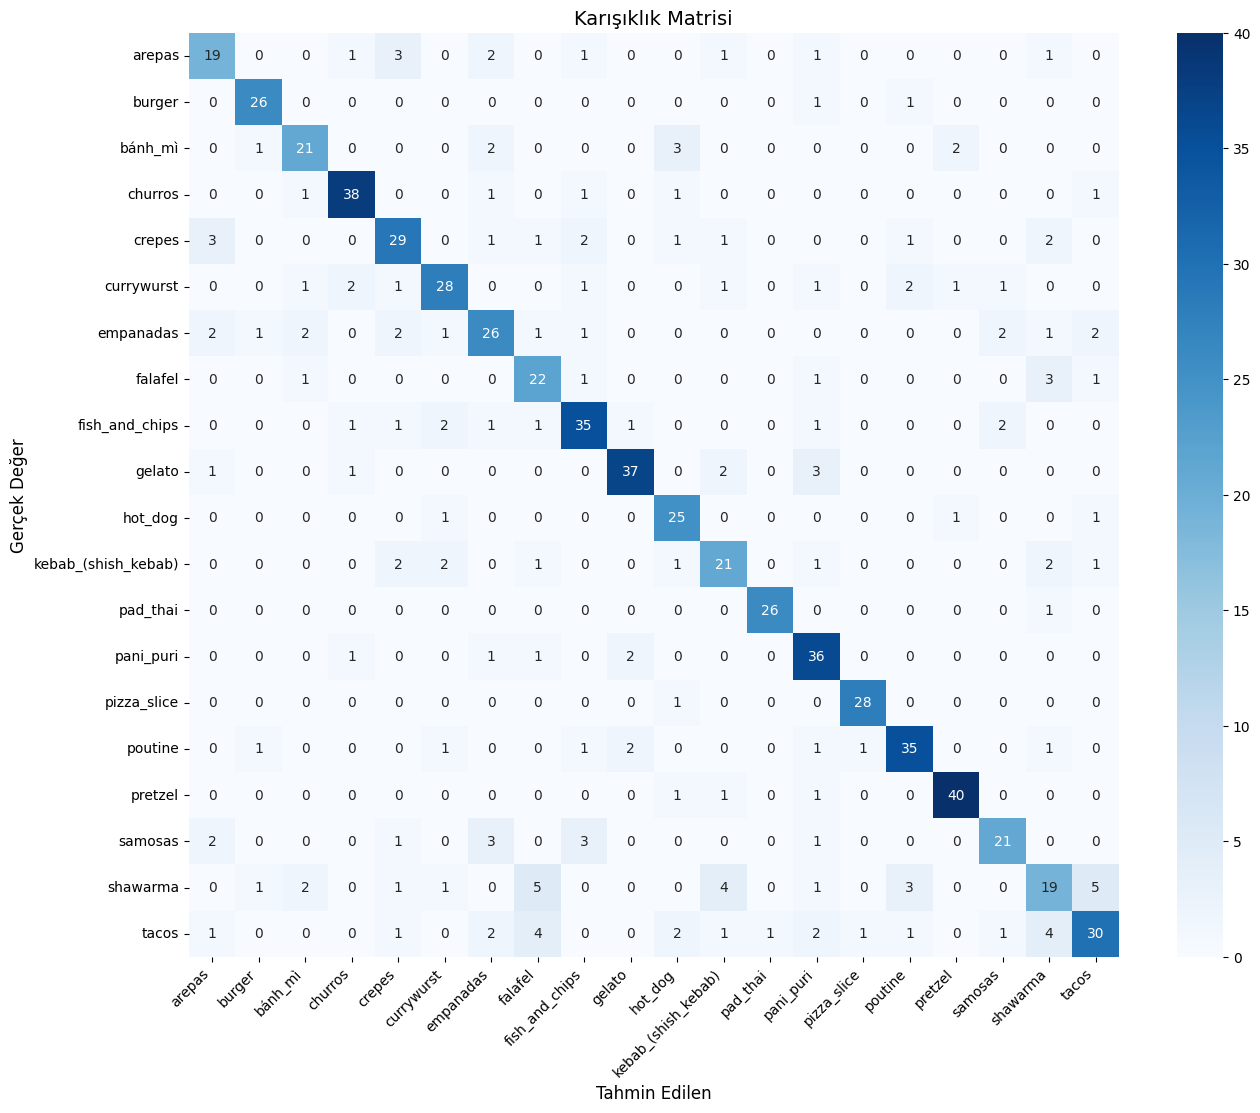


 DETAYLI SINIFLANDIRMA RAPORU:
                     precision  recall  f1-score  support
arepas                    0.68    0.66      0.67    29.00
burger                    0.87    0.93      0.90    28.00
bánh_mì                   0.75    0.72      0.74    29.00
churros                   0.86    0.88      0.87    43.00
crepes                    0.71    0.71      0.71    41.00
currywurst                0.78    0.72      0.75    39.00
empanadas                 0.67    0.63      0.65    41.00
falafel                   0.61    0.76      0.68    29.00
fish_and_chips            0.76    0.78      0.77    45.00
gelato                    0.88    0.84      0.86    44.00
hot_dog                   0.71    0.89      0.79    28.00
kebab_(shish_kebab)       0.66    0.68      0.67    31.00
pad_thai                  0.96    0.96      0.96    27.00
pani_puri                 0.71    0.88      0.78    41.00
pizza_slice               0.93    0.97      0.95    29.00
poutine                   0.81    0.81  

In [ ]:
# Hızlı değerlendirme
print("\nHızlı değerlendirme:")
model.load_weights("fast_model.h5")
loss, acc = model.evaluate(val_ds)
print(f"Validation Accuracy: {acc:.2%}")

def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(15,12))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.title('Karışıklık Matrisi', fontsize=14)
    plt.xlabel('Tahmin Edilen', fontsize=12)
    plt.ylabel('Gerçek Değer', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.show()

# 2. Sınıflandırma Değerlendirmeleri
def print_classification_report(y_true, y_pred, classes):
    report = classification_report(y_true, y_pred, target_names=classes, output_dict=True)
    df_report = pd.DataFrame(report).transpose()
    print("\n DETAYLI SINIFLANDIRMA RAPORU:")
    print(df_report.round(2))
    return df_report

# Değerlendirme
print("\n Hızlı Değerlendirme Sonuçları:")
val_loss, val_acc = model.evaluate(val_ds)
print(f"\n Validation Doğruluk: {val_acc:.2%}")

# Tahminler
y_pred = model.predict(val_ds)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.concatenate([np.argmax(y, axis=1) for _, y in val_ds], axis=0)

# Görselleştirmeler
plot_confusion_matrix(y_true, y_pred_classes, class_names)
report_df = print_classification_report(y_true, y_pred_classes, class_names)

# En kötü performans gösteren 3 sınıf
worst_classes = report_df.iloc[:-3, :].sort_values('f1-score').head(3)
print("\n En Zor Sınıflar (F1-Score'a göre):")
print(worst_classes[['precision', 'recall', 'f1-score']])